# Astrometry Response functions

In [2]:
import numpy as np
import matplotlib
from matplotlib import colormaps
import matplotlib.pyplot as plt
import healpy as hp
import itertools
#font = {'family' : 'Latin Modern Roman',
#        'weight' : 'bold',
#        'size'   : 16}
#matplotlib.rc('font',**font)

## Maps

In [3]:
# unit vector in R3, given two angles, \theta E[0,pi] and \phi E[0,2pi]
def skyvec(theta,phi): 
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    ct = np.cos(theta)
    return np.array([st*cp,st*sp,ct])

For $H^{(0)}_{ij} (n,n')$

In [4]:
I_3 = np.eye(3)

def GTanalytic_F0(zeta):
    y = (1-np.cos(zeta))/2
    prefac = np.pi / (3* (1-y)**2 )
    bracket = (1 - 8*y + 7*y**2 -6*np.log(y)*y**2 )
    # return fourpi/3 - 8*fourpi*y/3 + 7*fourpi*y**2/3 - 2*fourpi*y**2*np.log(y)
    return prefac*bracket

def GTanalytic_Hij(theta):
    n1 = np.array([0.,0.,1])
    n2 = np.array([np.sin(theta),0,np.cos(theta)])
    y = (1-np.dot(n1,n2))/2
    # term_1 = np.einsum('i,j->ij',n1,n1) + np.einsum('i,j->ij',n2,n2) 
    # term_2 =  np.cos(theta)*( np.einsum('i,j->ij',n2,n1) + np.einsum('i,j->ij',n1,n2))
    # geom = I_3 + (term_2 - term_1)/(1-np.cos(theta))
    term_1 = np.einsum('i,j->ij',n1,n1) + np.einsum('i,j->ij',n2,n2)
    term_2 = -np.einsum('i,j->ij',n2,n1) + np.cos(zeta)*np.einsum('i,j->ij',n1,n2)
    geom = I_3*(2-2*y) - term_1 + term_2
    f0 = GTanalytic_F0(theta)
    return geom*f0

In [5]:
#m1=[0,0,1]
#m2=[1,0,0]
#someth =np.einsum('i,j->ij',m1,m2) # This operation gives an Outer product of two vectors.
#print(someth)

For $H^{(1)}_{ij} (n,n',v)$

In [5]:
def GT_analytic_alpha(theta,v=np.array([0,1,0])):
    y = (1-np.cos(theta))/2
    n1 = np.array([0.,0.,1])
    n2 = np.array([np.sin(theta),0,np.cos(theta)])
    n1v = np.dot(n1,v)
    # print(v,n1)
    n2v = np.dot(n2,v)
    num = -np.pi*(2*y-1)*(n1v-n2v)*(n1v+n2v)*((y-1)*(2*y+1) - 3*y*np.log(y))
    den = 6*n1v*(y-1)**3
    # print(den)
    return num/den

def GT_analytic_beta(theta,v=np.array([0,1,0])):
    y = (1-np.cos(theta))/2
    n1 = np.array([0.,0.,1])
    n2 = np.array([np.sin(theta),0,np.cos(theta)])
    n1v = np.dot(n1,v)
    n2v = np.dot(n2,v)
    num = np.pi*y*(n1v+n2v)*((y-1)*(2*y+1) - 3*y*np.log(y))
    den = 3*n1v*(y-1)**2
    # print(den)
    return num/den


def GTanalytic_Hij_1(theta,v=np.array([0,1,0])):
    n1 = np.array([0.,0.,1.])
    n2 = np.array([np.sin(theta),0,np.cos(theta)])
    y = (1-np.cos(theta))/2
    n1v = np.dot(n1,v)
    n2v = np.dot(n2,v)
    alpha = GT_analytic_alpha(theta,v=v)
    beta = GT_analytic_beta(theta,v=v)
    t1 = I_3 * (alpha*(2*y+1/(1-2*y) - 1) -2*beta*n2v)
    t2 = alpha*(np.einsum('i,j->ij',n1,n2)+np.einsum('i,j->ij',n2,n1)) + np.einsum('i,j->ij',n1,n1)*( alpha/(2*y-1) + 2*beta*n2v)
    t3 = np.einsum('i,j->ij',n2,n2)*alpha/(2*y-1) + 2*beta*(2*y-1)*np.einsum('i,j->ij',n1,v) + 2*beta*np.einsum('i,j->ij',n2,v)
    # coeff_alpha = 4*y*(y-1)*I_3 + np.einsum('i,j->ij',n1,n1) + np.einsum('i,j->ij',n2,n2) +\
    #             (2*y-1)*(np.einsum('i,j->ij',n1,n2)+np.einsum('i,j->ij',n2,n1))
    # coeff_beta = n2v*np.einsum('i,j->ij',n1,n2) + np.einsum('i,j->ij',n2,v) + (2*y-1)*np.einsum('i,j->ij',n1,v) - n2v*I_3
    # term_1 = -np.einsum('i,j->ij',n2,n1) + np.cos(theta)*np.einsum('i,j->ij',n1,n2)
    # term_2 = np.einsum('i,j->ij',n1,n1) + np.einsum('i,j->ij',n2,n2)
    # geom = I_3*(2-2*y) - term_2 + term_1
    # f0 = np.sum((n1+n2)*v,axis=0)*GTanalytic_F1(theta)
    return t1+t2+t3 #alpha*coeff_alpha/(2*y-1) + 2*beta*coeff_beta

In [6]:
def gammadipole(v,p,q):
    pq = np.dot(p,q)
    pv = np.dot(p,v)
    qv = np.dot(q,v)
    if pq==1:
        fac = 4/3 - pq
    else:
        fac = 4/3 - pq - 2*(1-pq)*np.log((1-pq)/2)/(1+pq)
    return fac*(pv+qv)

In [10]:
np.random.seed(4)
npsr = 120
npair = npsr*(npsr-1)/2
phi = np.random.uniform(0,2*np.pi,npsr)
theta = np.arccos(np.random.uniform(-1,1,npsr))

nside = 64
npix = hp.nside2npix(nside)

#frame velocity 
vtheta, vphi = hp.pix2ang(nside, np.arange(npix))
vdir = skyvec(vtheta,vphi)

gammaN = np.zeros(npix)

for psrpair in itertools.combinations(np.arange(npsr),2):
    idx_p,idx_q = psrpair
    p = skyvec(theta[idx_p],phi[idx_p])
    q = skyvec(theta[idx_q],phi[idx_q])           
    gammaN+= gammadipole(vdir,p,q)

print(vdir.T)

[[ 0.00902091  0.00902091  0.99991862]
 [-0.00902091  0.00902091  0.99991862]
 [-0.00902091 -0.00902091  0.99991862]
 ...
 [-0.00902091  0.00902091 -0.99991862]
 [-0.00902091 -0.00902091 -0.99991862]
 [ 0.00902091 -0.00902091 -0.99991862]]


In [11]:
print(gammaN)

[ 1144.29351438  1154.70549374  1183.98309254 ... -1173.57111318
 -1144.29351438 -1154.70549374]


0.0840528141396559


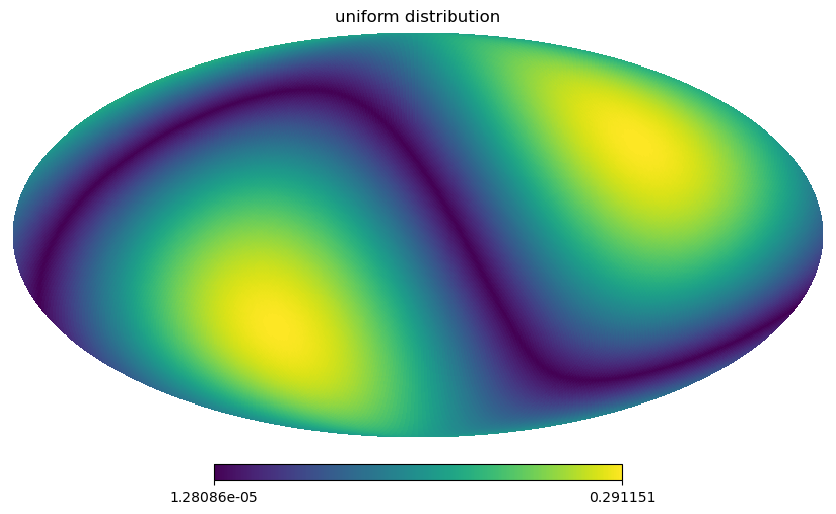

In [16]:
print(np.std(abs(gammaN))/npair)
hp.mollview(abs(gammaN)/npair,title='uniform distribution')